In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class GPDM:
  def __init__(self, obs_dim, latend_dim, device="cuda" ):
    self.D = obs_dim
    self.Dz = latend_dim
    self.device = device

  def k(self, xi, xj, kparams):
    #return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 
    return kparams[0] * torch.exp(-0.5 * kparams[1] * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj, dim, kparams ):
    a = xi.view(-1,1,dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,dim).repeat(len(xi), 1, 1)
    return self.k(a,b, kparams).float()

  def learn(self, x, num_itr, num_batch):
    self.N = x.shape[0]
    self.D = x.shape[1]
    self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
    self.params = torch.tensor( np.log([1, 1, 1, 1, 1, 1, 1, 1]), device=self.device, requires_grad=True )

    # PCAで初期化
    self.pca = PCA(n_components=self.Dz)
    self.z = torch.tensor( self.pca.fit_transform(x), dtype=torch.float32 ,requires_grad=True, device=self.device  )
    
    # 時間をずらす
    self.z0 = self.z[:self.N-1]
    self.z1 = self.z[1:]

    # ランダムな初期化
    #self.z = torch.tensor( np.random.rand(self.N, self.Dz), dtype=torch.float32 ,requires_grad=True  )


    optimizer = torch.optim.Adam( [self.params, self.z], lr=0.001)
    for i in range(num_itr):
      # ミニバッチ取り出し
      batch = np.random.choice(self.N-1, num_batch)
      x_batch = self.x[batch]
      z0_batch = self.z0[batch]
      z1_batch = self.z1[batch]

      # 負の対数尤度（コスト関数）を定義
      # カーネルのパラメータ
      self.kparams_x = [ torch.exp(self.params[0]), torch.exp(self.params[1])]
      self.kparams_z = [ torch.exp(self.params[2]), torch.exp(self.params[3])]

      # xに関する変数
      self.alphax = torch.exp(self.params[4])
      self.betax =  torch.exp(self.params[5])+0.001
      Kx = self.alphax * self.cov(z0_batch, z0_batch, self.Dz, self.kparams_x) + self.betax * torch.eye(num_batch, num_batch, device=self.device)
      Kx_inv = torch.inverse( Kx )

      # zに関する変数
      self.alphaz = torch.exp(self.params[6])
      self.betaz =  torch.exp(self.params[7])+0.001
      Kz = self.alphaz * self.cov(z0_batch, z0_batch, self.Dz, self.kparams_z) + self.betaz * torch.eye(num_batch, num_batch, device=self.device)
      Kz_inv = torch.inverse( Kz )

      loss = 1/2 * torch.trace( torch.mm( torch.mm( Kx_inv, x_batch ), torch.t( x_batch ) ) )
      loss += 1/2 * torch.trace( torch.mm( torch.mm( Kz_inv, z1_batch ), torch.t(z1_batch) ) )
      loss += self.Dz/2 * torch.logdet( Kz ) + self.D/2 * torch.logdet( Kx )

      # 最適化
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i%10==0:
        print(loss, i)
        z = self.z.detach().cpu().numpy()
        plt.plot( z[:,0], z[:,1], "o-" )
        plt.show()

    self.Kz = self.alphaz * self.cov(self.z[:-1], self.z[:-1], self.Dz, self.kparams_z) + self.betaz * torch.eye(self.N-1, self.N-1, device=self.device)
    self.Kz_inv = torch.inverse( self.Kz )

    return self.z.detach().cpu().numpy()

  def predict_next_z(self, pre_z ):
    pre_z = torch.tensor(pre_z, device=self.device).reshape(-1, self.Dz)

    kz = self.cov( pre_z, self.z[:-1], self.Dz, self.kparams_z )
    k = self.cov( pre_z, pre_z, self.Dz, self.kparams_z) + 1.0/self.betaz

    mu = torch.mm( torch.mm( kz, self.Kz_inv ), self.z[1:].reshape(-1,self.Dz) )
    sig = k - torch.mm( kz, torch.mm(self.Kz_inv, torch.t(kz)) )

    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()*np.eye(self.Dz)

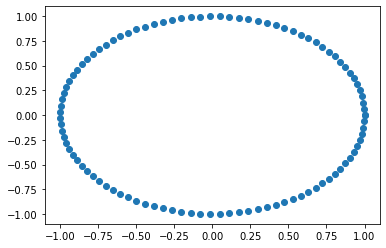

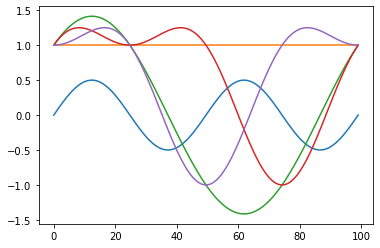

In [44]:
N = 100
D = 5

# 真の潜在変数を生成
t = np.linspace( 0, 2*np.pi, N )
z_true = np.zeros( (N, 2)  )

z_true[:,0] = np.cos(t)
z_true[:,1] = np.sin(t)

plt.plot( z_true[:,0], z_true[:,1], "o" )

# 潜在変数を適当に高次限化
x = np.zeros( (N, D) )
x[:,0] = [ z1*z2 for (z1,z2) in z_true ] 
x[:,1] = [ z1*z1+z2*z2 for (z1,z2) in z_true ] 
x[:,2] = [ z1 + z2 for (z1,z2) in z_true ] 
x[:,3] = [ z1*z1+z2 for (z1,z2) in z_true ] 
x[:,4] = [ z2*z2+z1 for (z1,z2) in z_true ] 

plt.figure()
for i in range(D):
  plt.plot( range(N), x[:,i])

tensor(41.4808, grad_fn=<AddBackward0>) 0


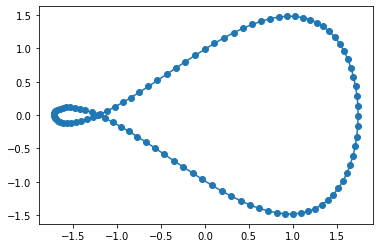

tensor(40.0535, grad_fn=<AddBackward0>) 10


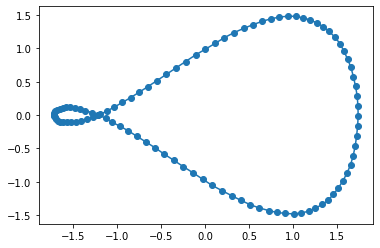

tensor(33.9233, grad_fn=<AddBackward0>) 20


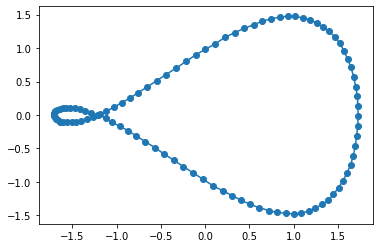

tensor(36.3511, grad_fn=<AddBackward0>) 30


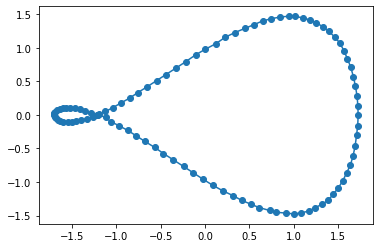

tensor(33.8737, grad_fn=<AddBackward0>) 40


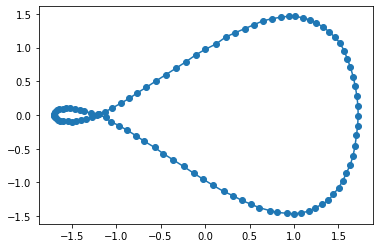

tensor(34.0743, grad_fn=<AddBackward0>) 50


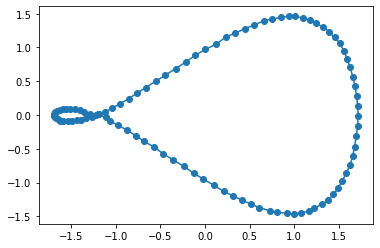

tensor(33.3326, grad_fn=<AddBackward0>) 60


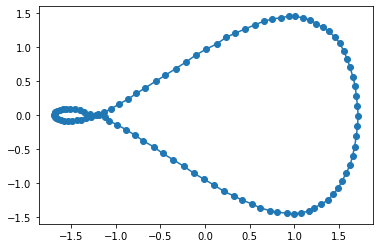

tensor(33.1288, grad_fn=<AddBackward0>) 70


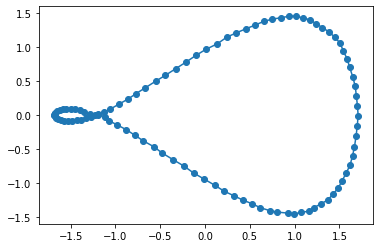

tensor(33.1220, grad_fn=<AddBackward0>) 80


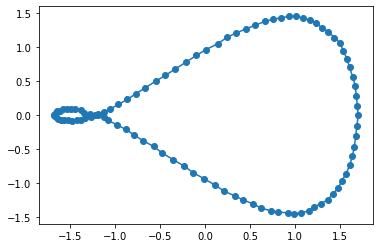

tensor(32.4225, grad_fn=<AddBackward0>) 90


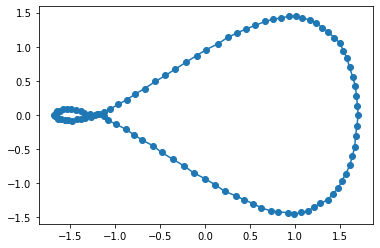

tensor(28.0397, grad_fn=<AddBackward0>) 100


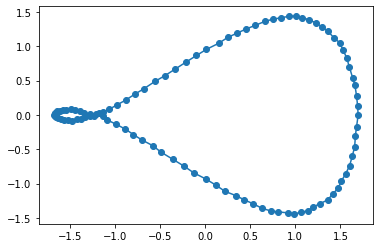

tensor(29.8130, grad_fn=<AddBackward0>) 110


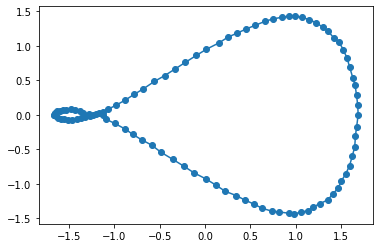

tensor(31.2483, grad_fn=<AddBackward0>) 120


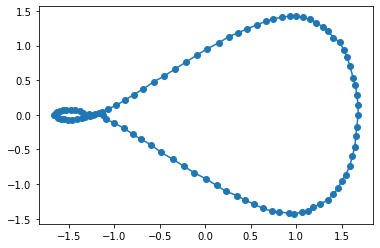

tensor(29.1526, grad_fn=<AddBackward0>) 130


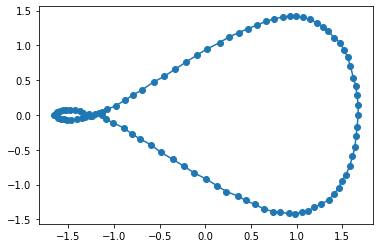

tensor(26.9619, grad_fn=<AddBackward0>) 140


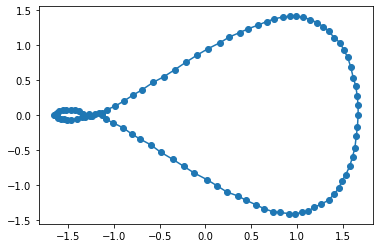

tensor(27.7096, grad_fn=<AddBackward0>) 150


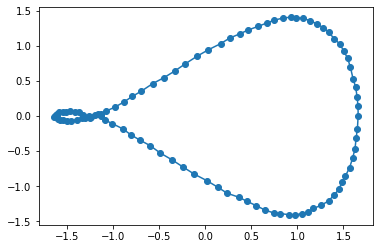

tensor(25.3475, grad_fn=<AddBackward0>) 160


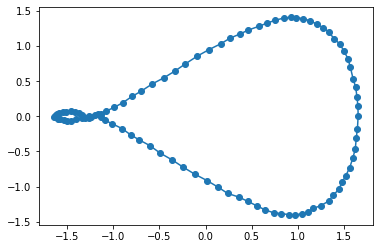

tensor(24.1338, grad_fn=<AddBackward0>) 170


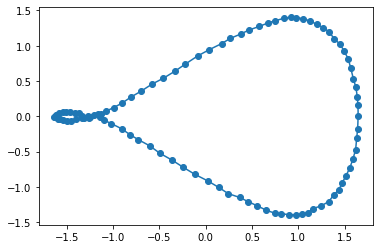

tensor(24.4572, grad_fn=<AddBackward0>) 180


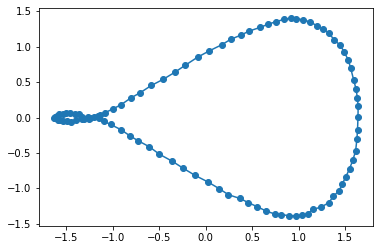

tensor(26.5857, grad_fn=<AddBackward0>) 190


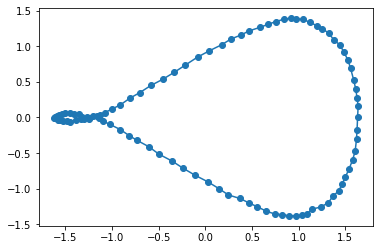

In [46]:
gp = GPDM(N, 2, "cpu")

# 学習
z = gp.learn(x, 200, 20)

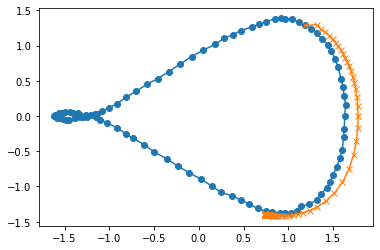

In [47]:
# 潜在変数を予測
z_sequence = []
z_pred = z[50]
z_sequence.append( z_pred )
for i in range(100):
  mu, sig = gp.predict_next_z( z_pred )
  z_pred = mu
  z_sequence.append( z_pred )

z_sequence = np.array( z_sequence )
plt.plot( z[:,0], z[:,1], "o-" )
plt.plot( z_sequence[:,0], z_sequence[:,1], "x-" )
plt.show()